# Trying out constraints

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import aps_ai
import aps_ai.beamline34IDC.optimization.common as opt_common
import aps_ai.beamline34IDC.optimization.movers as movers
import IPython
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps_ai.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps_ai.common.util import clean_up
from aps_ai.common.util.shadow.common import (
    get_shadow_beam_spatial_distribution,
    load_shadow_beam,
    plot_shadow_beam_spatial_distribution,
)
from tqdm import tqdm

%matplotlib inline

In [3]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
print(DEFAULT_RANDOM_SEED)

66879


In [4]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/jupyter/optuna_test


In [5]:
root_dir = Path(aps_ai.__path__[0]).parents[0]
base_dir = root_dir / 'work_directory'
orig_work_dir = base_dir /'34-ID'
temp_work_dir = base_dir / f'tmp_work_dir_34-ID-{DEFAULT_RANDOM_SEED}'
temp_work_dir.mkdir(exist_ok=True)

In [6]:
dat_files = list(orig_work_dir.glob('*.dat')) + list(orig_work_dir.glob('*.ini'))
for df in dat_files:
    shutil.copy(df, temp_work_dir)

In [7]:
os.chdir(temp_work_dir)

In [8]:
input_beam_path = "primary_optics_system_beam.dat"

In [9]:
move_motors_ranges = {'hkb_1': [-5, 5], 
                      'vkb_1': [-5, 5],
                      'hkb_2': [-5, 5],
                      'vkb_2': [-5, 5],
                      'hkb_3': [-0.01, 0.01],
                      'vkb_3': [-0.01, 0.01],
                      'hkb_4': [-5, 5], 
                      'vkb_4': [-5, 5]}
hkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'hkb' in k}
vkb_motors_ranges = {k:v for k, v in move_motors_ranges.items() if 'vkb' in k}

In [10]:
save_figs = False

if save_figs:
    motors_str = move_motors[0] if len(move_motors) == 1 else '_'.join(move_motors)
    fig_save_path = f'{orig_work_dir}/figures/{motors_str}/'
    if not os.path.isdir(fig_save_path):
        os.mkdir(fig_save_path)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

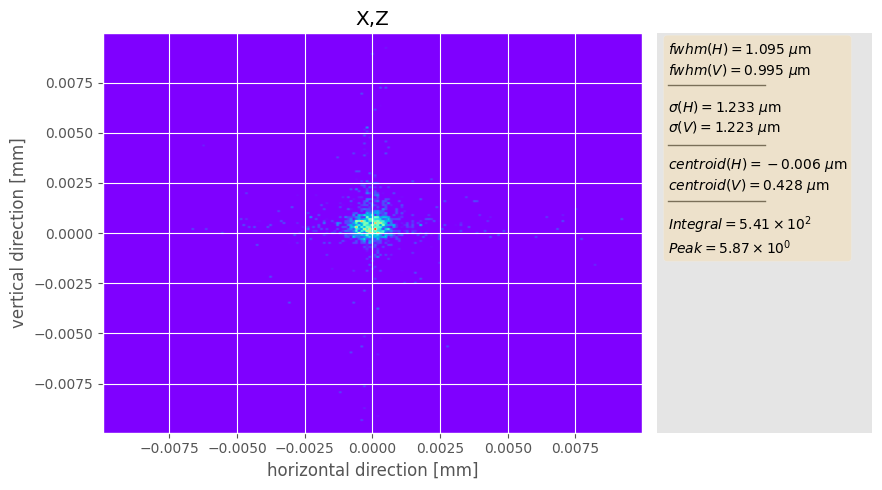

In [82]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [83]:
initial_absolute_positions = np.array(movers.get_absolute_positions(focusing_system, list(move_motors_ranges.keys())))
print(initial_absolute_positions)

[215.5 144.  112.5 231.5   3.    3.    0.    0. ]


In [84]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.00041717203996423136, 0.002736531805781683)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

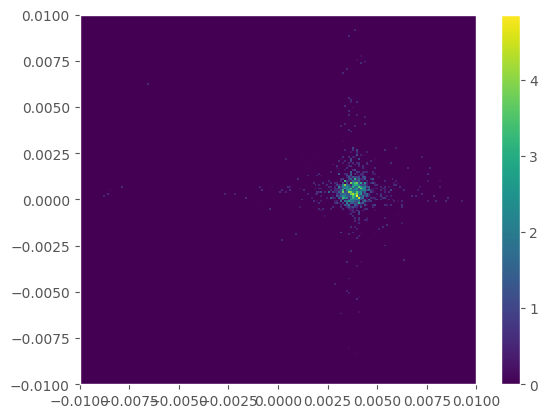

In [85]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [86]:
hist.data_2D.sum()

538.132761538106

In [114]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

0.0038424827215943133 0.0027645541974954586


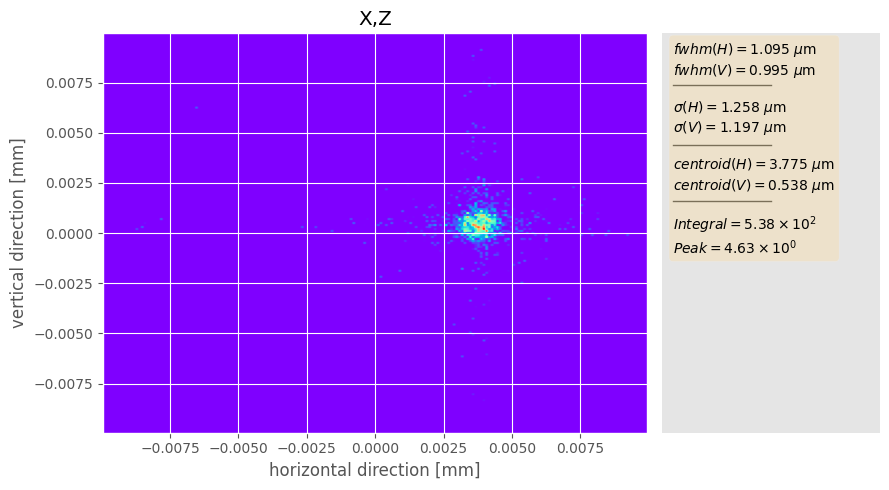

In [115]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [129]:
opt_trial = OptunaOptimizer(
    focusing_system,
    motor_types=list(move_motors_ranges.keys()),
    random_seed=DEFAULT_RANDOM_SEED,
    loss_parameters=["centroid", "sigma"],
    loss_min_value=5e-4,
    use_gaussian_fit=False,
    multi_objective_optimization=True,
    camera_xrange=[-0.01, 0.01],
    camera_yrange=[-0.01, 0.01],
    camera_nbins=201,
)
# opt_trial.motor_ranges = centroid_ranges

In [130]:
constraints = {"integral_intensity": 500, "centroid":5e-3, "sigma":5e-3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=False,#True,
    use_discrete_space=True,
    moo_thresholds={"centroid": 1e-3, "sigma": 2e-3},
    constraints=constraints,
)

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:300: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler(
[I 2022-10-17 22:04:21,980] A new study created in memory with name: no-name-9db9a78c-70e4-4c3a-b48f-61039022e46e


In [131]:
opt_trial.trials(20, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:421: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
[I 2022-10-17 22:04:23,703] Trial 0 finished with values: [0.000512223677941

In [132]:
opt_trial.study.best_trials

[FrozenTrial(number=0, values=[0.0005122236779411146, 0.0017053770183455168], datetime_start=datetime.datetime(2022, 10, 17, 22, 4, 22, 925329), datetime_complete=datetime.datetime(2022, 10, 17, 22, 4, 23, 703164), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'integral_intensity_constraint': -1, 'cent

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


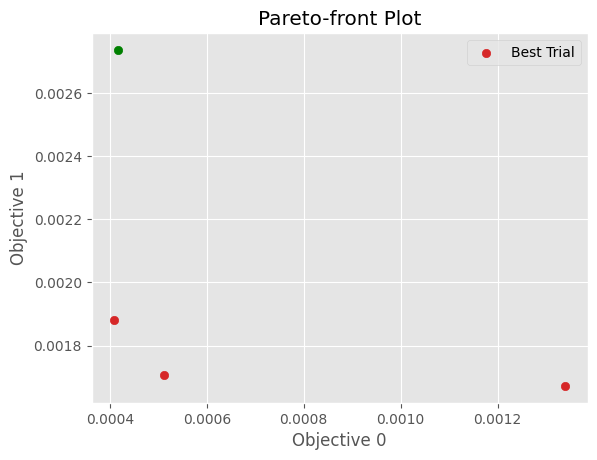

In [133]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [134]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-13.950718224908249 0.6034789076226019
-14.07783805060719 0.4856346855851102
-13.00943670802667 0.603310717304424


[0.0005122236779411146, 0.0017053770183455168] 0.6034789076226019


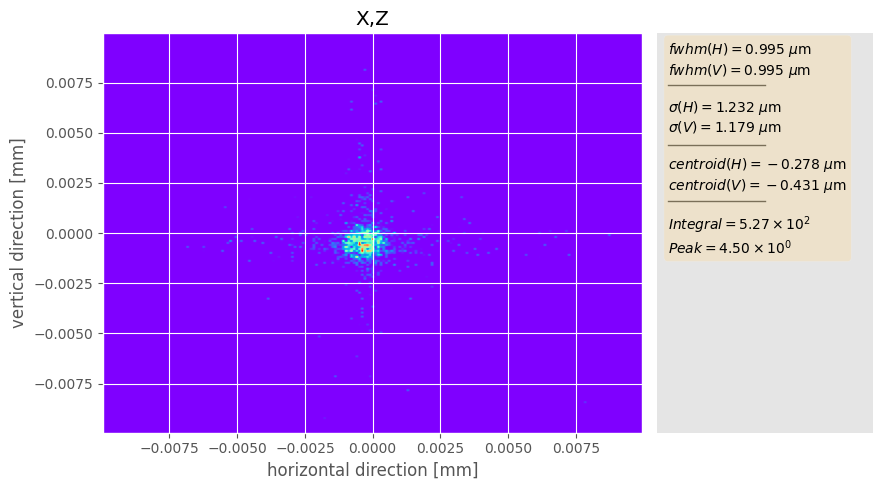

[0.000409055765357298, 0.0018805725793836926] 0.4856346855851102


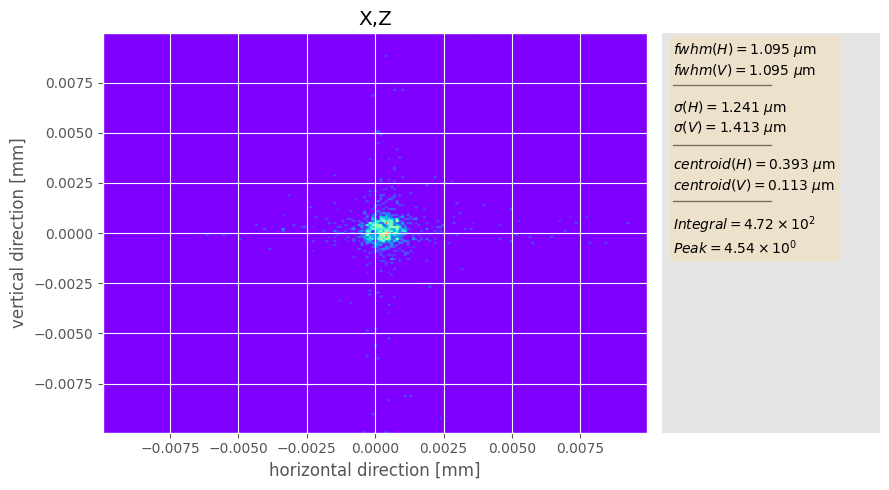

[0.0013391809359917185, 0.0016719918908095091] 0.603310717304424


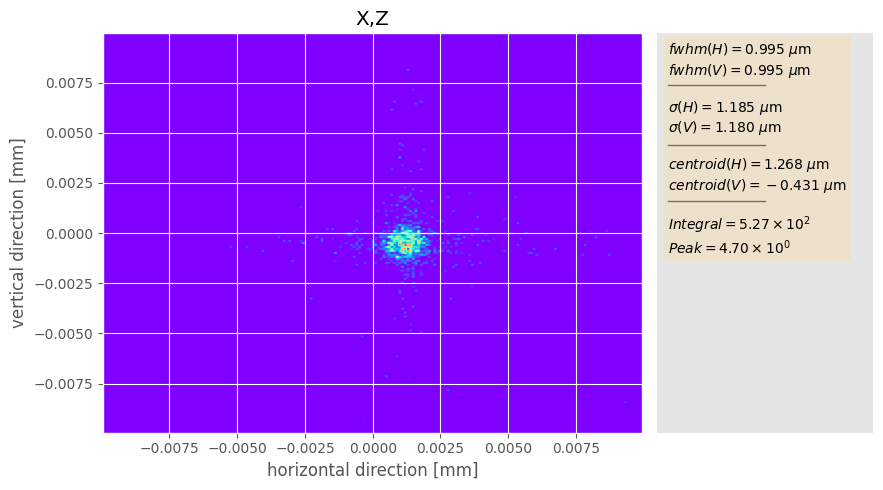

In [135]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [136]:
opt_trial.trials(20)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:31,582] Trial 20 finished with values: [0.0024444525589142675, 0.0019710106934648017] and parameters: {'hkb_1': -0.6734, 'vkb_1': -0.09539999999999971, 'hkb_2': 0.3703000000000003, 'vkb_2': -1.1886999999999999, 'hkb_3': -0.00475, 'vkb_3': -0.00475, 'hkb_4': 0.9000000000000004, 'vkb_4': 3.0999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:35,302] Trial 21 finished with values: [0.001598627573140713, 0.0017262475462712853] and parameters: {'hkb_1': -0.6070000000000002, 'vkb_1': 0.015000000000000568, 'hkb_2': -2.2081999999999997, 'vkb_2': 2.4729, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.0012499999999999994, 'hkb_4': -1.5, 'vkb_4': 0.20000000000000018}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:38,532] Trial 22 finished with values: [0.0005237214405162418, 0.001748321140568594] and parameters: {'hkb_1': -1.4105999999999996, 'vkb_1': -0.8503999999999996, 'hkb_2': 1.8369, 'vkb_2': -0.4131999999999998, 'hkb_3': -0.0012499999999999994, 'vkb_3': 0.0005000000000000004, 'hkb_4': -0.1999999999999993, 'vkb_4': 0.10000000000000053}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:41,683] Trial 23 finished with values: [0.000641749999594517, 0.0020081366264098083] and parameters: {'hkb_1': 0.8196000000000003, 'vkb_1': -0.5727000000000002, 'hkb_2': -2.1022, 'vkb_2': 2.686400000000001, 'hkb_3': 0.004, 'vkb_3': 0.0022500000000000003, 'hkb_4': 0.7000000000000002, 'vkb_4': 0.40000000000000036}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:44,789] Trial 24 finished with values: [0.001356895337616147, 0.001857645251367637] and parameters: {'hkb_1': -2.5419, 'vkb_1': -3.5853, 'hkb_2': 0.8894000000000002, 'vkb_2': 0.9031000000000002, 'hkb_3': 0.0005000000000000004, 'vkb_3': 0.0005000000000000004, 'hkb_4': 1.1000000000000005, 'vkb_4': 0.9000000000000004}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:48,398] Trial 25 finished with values: [0.001076932969573006, 0.0020833981304512732] and parameters: {'hkb_1': -1.5768999999999997, 'vkb_1': -1.2178999999999998, 'hkb_2': 0.8732000000000006, 'vkb_2': 3.764800000000001, 'hkb_3': -0.0012499999999999994, 'vkb_3': 0.0022500000000000003, 'hkb_4': -1.1999999999999997, 'vkb_4': 0.8000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:51,832] Trial 26 finished with values: [0.0019014613692027865, 0.0018724705045640878] and parameters: {'hkb_1': -0.9867999999999997, 'vkb_1': -1.3154999999999997, 'hkb_2': 2.2111, 'vkb_2': 2.3532, 'hkb_3': 0.0022500000000000003, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.0, 'vkb_4': -1.4}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:55,321] Trial 27 finished with values: [0.0006518015743685478, 0.002076911298394256] and parameters: {'hkb_1': -2.8001, 'vkb_1': 0.026500000000000412, 'hkb_2': 1.1381000000000006, 'vkb_2': 4.1774000000000004, 'hkb_3': 0.004, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.40000000000000036, 'vkb_4': 1.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:05:58,897] Trial 28 finished with values: [0.0009371491211072366, 0.0020583366479129416] and parameters: {'hkb_1': -1.6966999999999999, 'vkb_1': 1.3298000000000005, 'hkb_2': 2.9389000000000003, 'vkb_2': 0.37840000000000007, 'hkb_3': -0.01, 'vkb_3': -0.00825, 'hkb_4': -1.7999999999999998, 'vkb_4': 4.600000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:02,397] Trial 29 finished with values: [0.0009724604367714486, 0.001803031568729414] and parameters: {'hkb_1': -1.7702999999999998, 'vkb_1': -1.2254999999999998, 'hkb_2': 1.8674, 'vkb_2': 1.0189000000000004, 'hkb_3': -0.00475, 'vkb_3': 0.0005000000000000004, 'hkb_4': -0.5, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:06,201] Trial 30 finished with values: [0.0011969704056708553, 0.0018895433886884914] and parameters: {'hkb_1': -1.5448, 'vkb_1': -0.031799999999999606, 'hkb_2': -4.1785, 'vkb_2': -1.4552, 'hkb_3': 0.0075000000000000015, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.3000000000000007, 'vkb_4': 1.1000000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:10,033] Trial 31 finished with values: [0.0009224394490671373, 0.0019370125289655434] and parameters: {'hkb_1': -1.7738, 'vkb_1': -0.9257, 'hkb_2': 0.5692000000000004, 'vkb_2': -2.5233, 'hkb_3': 0.0005000000000000004, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.5, 'vkb_4': 1.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:13,659] Trial 32 finished with values: [0.0028603749810183895, 0.001800791072584147] and parameters: {'hkb_1': -4.8903, 'vkb_1': -1.3074, 'hkb_2': -1.4476999999999998, 'vkb_2': -0.14809999999999945, 'hkb_3': 0.00575, 'vkb_3': 0.0005000000000000004, 'hkb_4': -1.9, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:17,254] Trial 33 finished with values: [0.0007423965195785898, 0.0018424246904583128] and parameters: {'hkb_1': -2.2043, 'vkb_1': -2.512, 'hkb_2': -3.1178, 'vkb_2': 2.533200000000001, 'hkb_3': 0.00575, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.3000000000000007, 'vkb_4': 0.20000000000000018}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:20,801] Trial 34 finished with values: [0.0005923200165013594, 0.0018961440630762916] and parameters: {'hkb_1': -0.8944999999999999, 'vkb_1': 0.6127000000000002, 'hkb_2': 0.5903, 'vkb_2': 1.2585000000000006, 'hkb_3': 0.0022500000000000003, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.0, 'vkb_4': 1.1000000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:24,358] Trial 35 finished with values: [0.0017099733337301295, 0.0018578729075999518] and parameters: {'hkb_1': 1.7086000000000006, 'vkb_1': -3.8422, 'hkb_2': 2.3869000000000007, 'vkb_2': -1.5658999999999996, 'hkb_3': 0.0022500000000000003, 'vkb_3': 0.0005000000000000004, 'hkb_4': -1.5999999999999996, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:28,323] Trial 36 finished with values: [0.0017978021972856132, 0.0017620217544621689] and parameters: {'hkb_1': 2.9511000000000003, 'vkb_1': -1.0206, 'hkb_2': -1.4973999999999998, 'vkb_2': 0.8559000000000001, 'hkb_3': -0.003, 'vkb_3': 0.0005000000000000004, 'hkb_4': 0.6000000000000005, 'vkb_4': 0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:31,980] Trial 37 finished with values: [0.0028062210892902057, 0.0018332435368461038] and parameters: {'hkb_1': 0.8994, 'vkb_1': -2.846, 'hkb_2': 0.004400000000000404, 'vkb_2': 2.612, 'hkb_3': 0.00575, 'vkb_3': 0.0005000000000000004, 'hkb_4': -1.9, 'vkb_4': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:36,075] Trial 38 finished with values: [0.00016134424566898654, 0.001772340773343238] and parameters: {'hkb_1': 0.5734000000000004, 'vkb_1': -4.1905, 'hkb_2': -1.0305999999999997, 'vkb_2': 3.0495, 'hkb_3': -0.01, 'vkb_3': -0.00825, 'hkb_4': -2.6999999999999997, 'vkb_4': 4.600000000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:06:39,884] Trial 39 finished with values: [0.0013297993408983243, 0.0019382306404759797] and parameters: {'hkb_1': 4.2058, 'vkb_1': -3.4566999999999997, 'hkb_2': -4.7036999999999995, 'vkb_2': 2.7731000000000003, 'hkb_3': -0.006500000000000001, 'vkb_3': -0.00825, 'hkb_4': -0.7999999999999998, 'vkb_4': 4.800000000000001}. 


In [137]:
opt_trial.study.best_trials

[FrozenTrial(number=0, values=[0.0005122236779411146, 0.0017053770183455168], datetime_start=datetime.datetime(2022, 10, 17, 22, 4, 22, 925329), datetime_complete=datetime.datetime(2022, 10, 17, 22, 4, 23, 703164), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.0, 'vkb_3': 0.0, 'hkb_4': 0.0, 'vkb_4': 0.0}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'integral_intensity_constraint': -1, 'cent

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


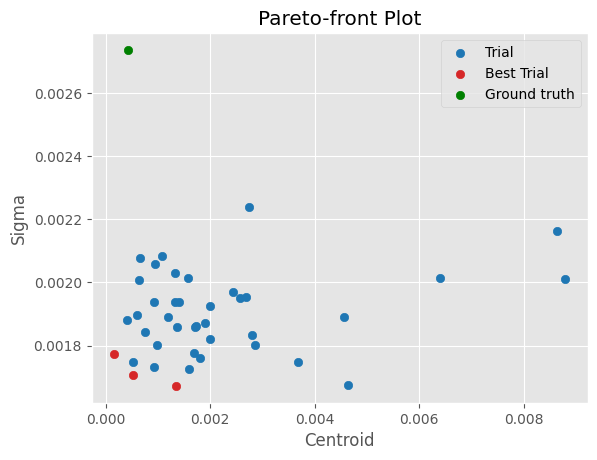

In [138]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [139]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.950718224908249
-13.00943670802667
-15.067424439034331


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

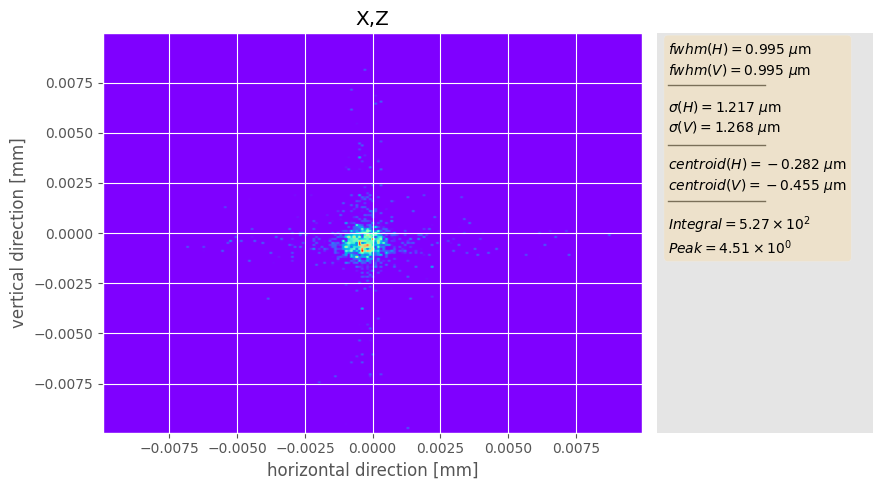

[0.0013391809359917185, 0.0016719918908095091] 0.603310717304424
BeamParameterOutput(parameter_value=0.0012497163649983947, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7fe8784fc070>, hist=<aps_ai.common.util.common.Histogram object at 0x7fe8784fc3d0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7fe8e97170d0>)


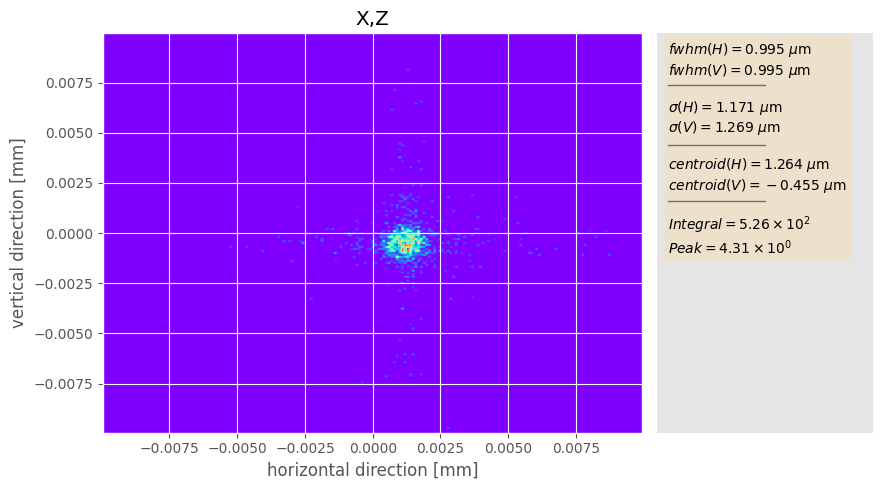

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

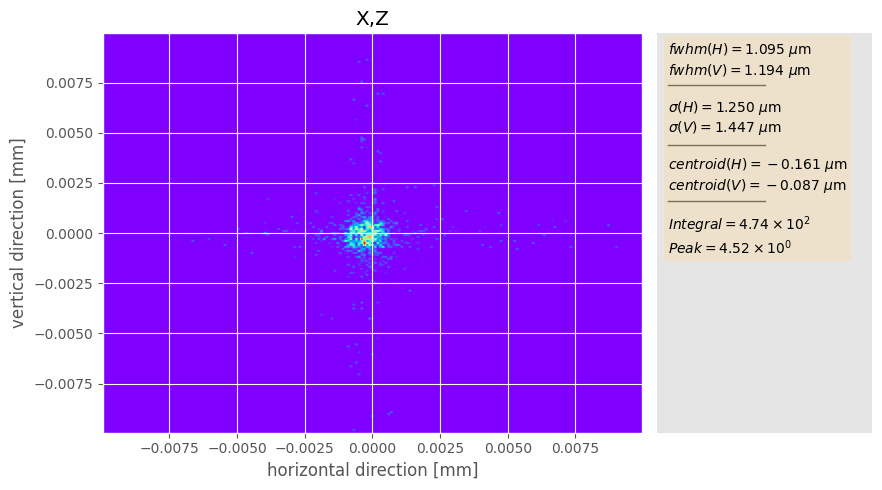

In [140]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [141]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

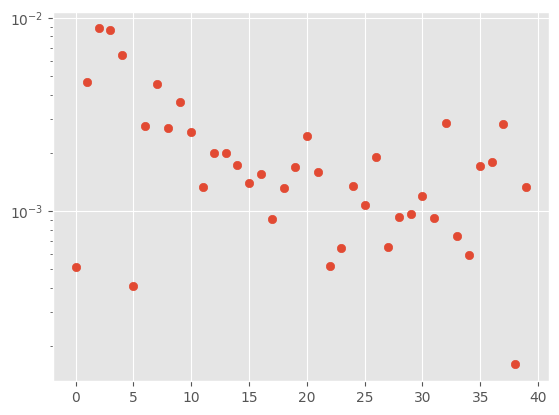

In [142]:
plt.scatter(tnums, centroids)
plt.yscale('log')

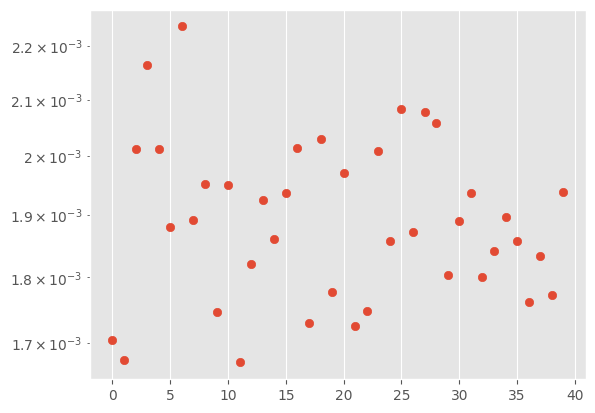

In [143]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

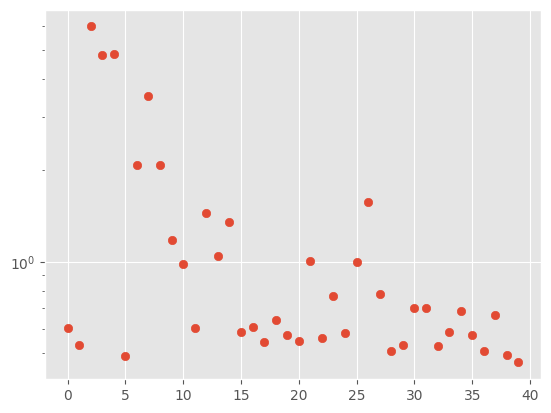

In [144]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [145]:
np.round(best_absolute_positions, 2)

array([[220.38, 140.47, 111.47, 233.75,   3.  ,   2.98,   0.63,   6.57],
       [220.38, 140.47, 111.47, 233.75,   3.  ,   2.98,  -1.77,   6.57],
       [220.95, 136.28, 110.44, 236.8 ,   2.99,   2.98,  -2.08,  11.18]])

In [146]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])

### Different starting structure + increased motor range

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

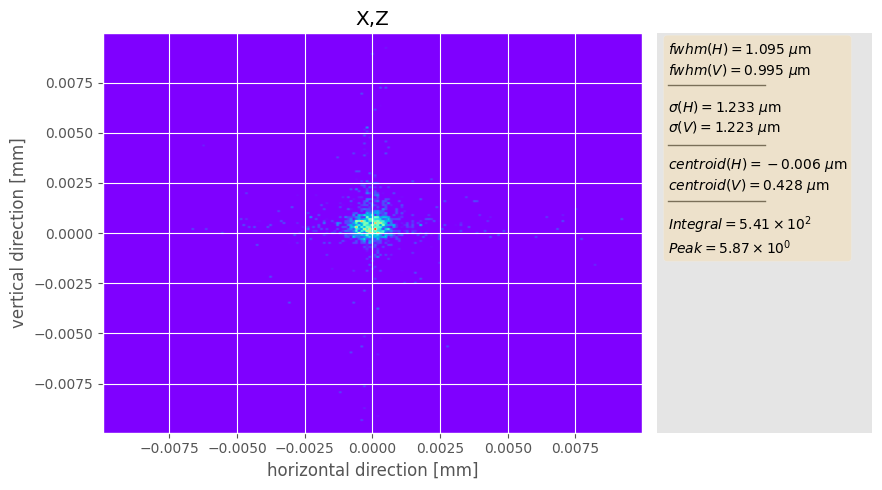

In [147]:
focusing_system = opt_common.reinitialize(input_beam_path=input_beam_path, bender=2)
beam, hist, dw = opt_common.get_beam_hist_dw(focusing_system, random_seed=DEFAULT_RANDOM_SEED)

plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [148]:
centroid_ground, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma_ground, *_ = opt_common.get_sigma(photon_beam=beam)
centroid_ground, sigma_ground

(0.00041717203996423136, 0.002736531805781683)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

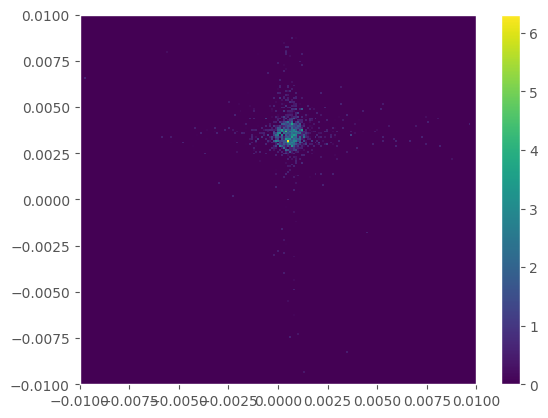

In [149]:
initial_movement, focusing_system, (beam, hist, dw) = opt_common.get_random_init(
    focusing_system,
    motor_types_and_ranges=move_motors_ranges,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    integral_threshold=300,
    nbins=201,
    random_seed=DEFAULT_RANDOM_SEED,
)
plt.pcolormesh(hist.vv, hist.hh, hist.data_2D.T)
plt.colorbar()
plt.show()

In [150]:
hist.data_2D.sum()

541.6701785268823

In [151]:
focusing_system = movers.move_motors(focusing_system, list(move_motors_ranges.keys()), initial_absolute_positions + initial_movement, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
0.0036457370635303906 0.0027037408069067632


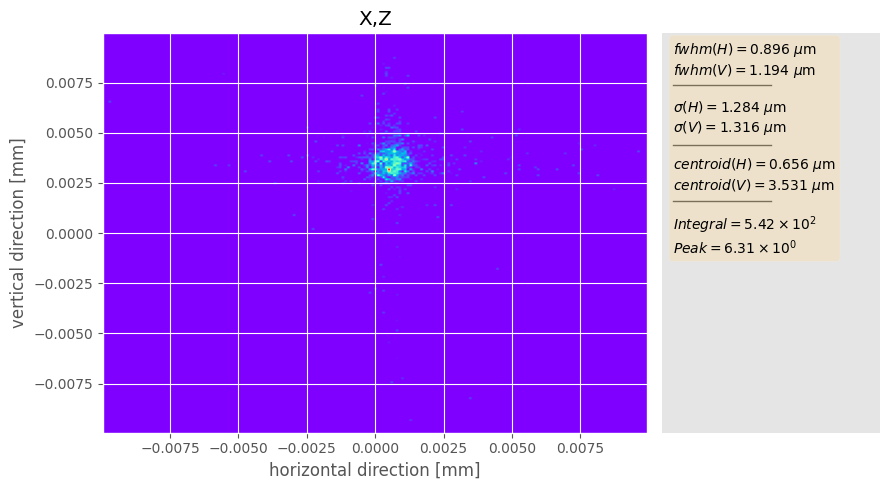

In [152]:
beam = opt_common.get_beam(focusing_system, random_seed=DEFAULT_RANDOM_SEED)
centroid, *_ = opt_common.get_centroid_distance(photon_beam=beam, random_seed=DEFAULT_RANDOM_SEED)
sigma, *_ = opt_common.get_sigma(photon_beam=beam)
print(centroid, sigma)


plot_shadow_beam_spatial_distribution(
    beam,
    xrange=[-0.01, 0.01],
    yrange=[-0.01, 0.01],
    nbins=201,
)

In [153]:
move_motors_ranges_2 = {k: [v[0] * 2, v[1] * 2] for k,v in move_motors_ranges.items()}

In [154]:

opt_trial = OptunaOptimizer(focusing_system, 
                            motor_types=list(move_motors_ranges.keys()), 
                            random_seed=DEFAULT_RANDOM_SEED, 
                            loss_parameters=['centroid', 'sigma'],
                            loss_min_value=5e-4,
                            use_gaussian_fit=False,
                            multi_objective_optimization=True,
                            camera_xrange=[-0.01, 0.01],
                            camera_yrange=[-0.01, 0.01],
                            camera_nbins=201)
#opt_trial.motor_ranges = centroid_ranges

In [155]:
constraints = {"integral_intensity": 500, "centroid":5e-3, "sigma":5e-3}
opt_trial.set_optimizer_options(
    motor_ranges=list(move_motors_ranges.values()),
    raise_prune_exception=False,#True,
    use_discrete_space=True,
    moo_thresholds={"centroid": 1e-3, "sigma": 2e-3},
    constraints=constraints,
)

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:300: ExperimentalWarning: BoTorchSampler is experimental (supported from v2.4.0). The interface can change in the future.
  base_sampler = optuna.integration.BoTorchSampler(
[I 2022-10-17 22:08:12,901] A new study created in memory with name: no-name-f2bf8b40-d539-4082-be1d-e14b24fdb41d


In [156]:
opt_trial.trials(20, trial_motor_types=['hkb_4', 'vkb_4', 'hkb_3', 'vkb_3'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps_ai/beamline34IDC/optimization/optuna_botorch.py:421: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'hkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:618: UserWarning: Fixed parameter 'vkb_3' with value 0.0 is out of range for distribution FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175).
  warnings.warn(
[I 2022-10-17 22:08:17,892] Trial 0 finished with values: [0.003591196890625

In [157]:
opt_trial.study.best_trials

[FrozenTrial(number=10, values=[0.00043202702979899284, 0.0017396415416890475], datetime_start=datetime.datetime(2022, 10, 17, 22, 8, 24, 466019), datetime_complete=datetime.datetime(2022, 10, 17, 22, 8, 26, 777924), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.4000000000000004, 'vkb_4': -0.7999999999999998}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'i

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/1036378160.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


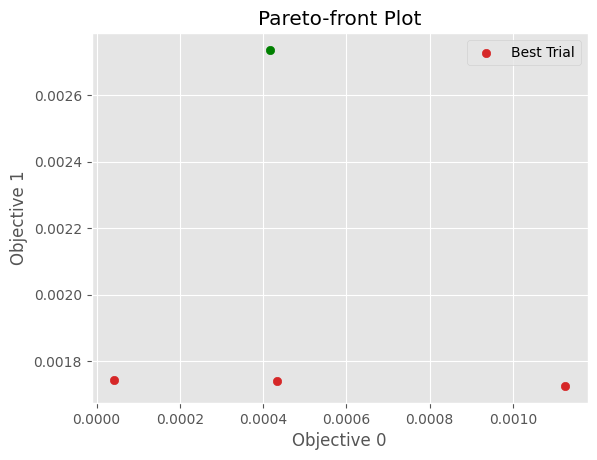

In [158]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
plt.scatter(centroid_ground, sigma_ground, color='green')

In [159]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs['wsum'])

-14.10109860020069 0.587965273989006
-13.151979122265928 0.7715940107357685
-16.4244690011505 0.5390793114962008


[0.00043202702979899284, 0.0017396415416890475] 0.587965273989006


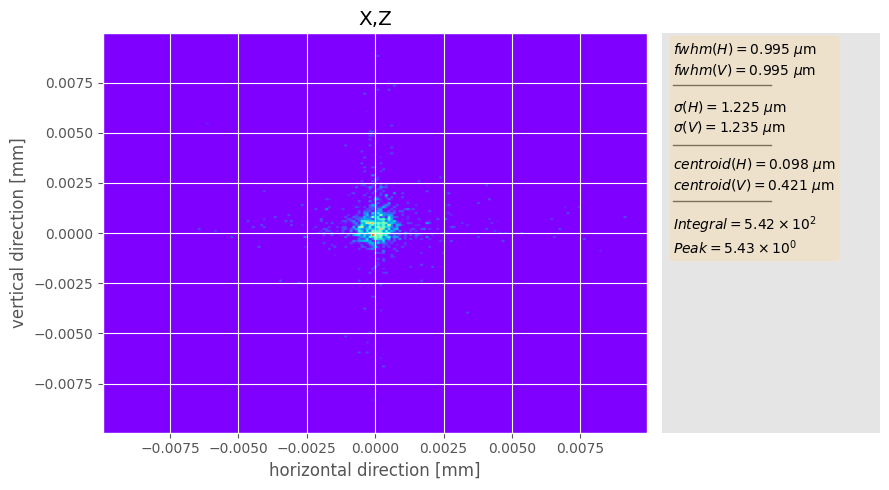

[0.001125139095771311, 0.0017256861974369257] 0.7715940107357685


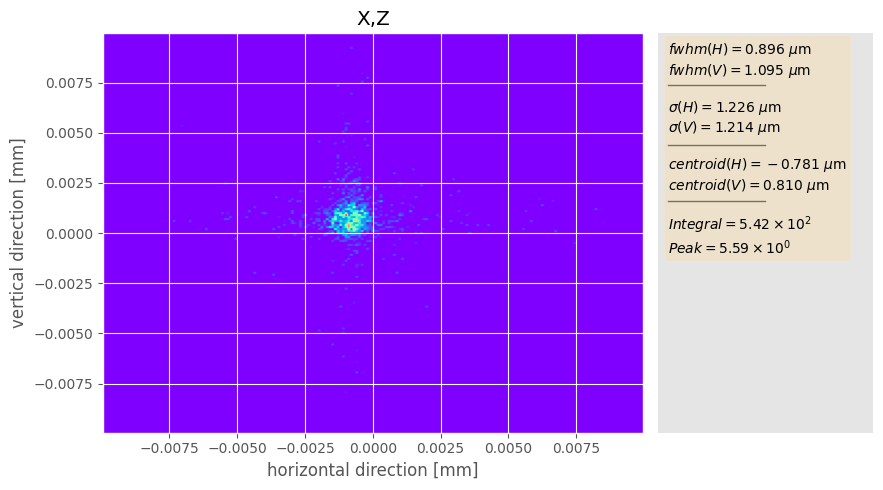

[4.222216804811069e-05, 0.0017434247806688843] 0.5390793114962008


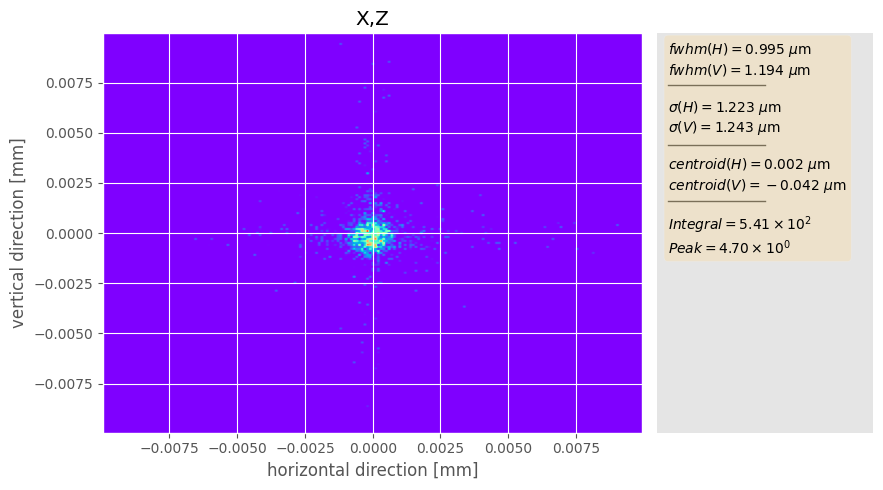

In [160]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values, t.user_attrs['wsum'])
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [161]:
opt_trial.trials(20)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:11,743] Trial 20 finished with values: [0.0022052266649576803, 0.001820731224761131] and parameters: {'hkb_1': 1.1472000000000007, 'vkb_1': -0.7363999999999997, 'hkb_2': -0.8911999999999995, 'vkb_2': 1.2532000000000005, 'hkb_3': 0.00925, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.4000000000000004, 'vkb_4': -2.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:15,574] Trial 21 finished with values: [0.0023199456611681267, 0.001834959669352522] and parameters: {'hkb_1': -0.8895, 'vkb_1': -0.6688000000000001, 'hkb_2': 0.27890000000000015, 'vkb_2': -0.7953000000000001, 'hkb_3': 0.0022500000000000003, 'vkb_3': -0.0012499999999999994, 'hkb_4': 3.200000000000001, 'vkb_4': -1.6999999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:19,401] Trial 22 finished with values: [0.001314782738524927, 0.0018039766899420131] and parameters: {'hkb_1': 2.7762000000000002, 'vkb_1': 1.8639000000000001, 'hkb_2': 0.03910000000000036, 'vkb_2': -1.101, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.9000000000000004, 'vkb_4': -0.5999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:23,661] Trial 23 finished with values: [0.0012643248070477555, 0.001812361439035037] and parameters: {'hkb_1': 2.5594, 'vkb_1': 2.0703000000000005, 'hkb_2': -1.9322999999999997, 'vkb_2': 1.8613, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00475, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.09999999999999964}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:27,075] Trial 24 finished with values: [0.0009400651361345877, 0.0017482039625744043] and parameters: {'hkb_1': -2.2483, 'vkb_1': 1.388, 'hkb_2': 0.6763000000000003, 'vkb_2': 3.4062, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00475, 'hkb_4': 1.5, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:30,638] Trial 25 finished with values: [0.000927326513387335, 0.001740619132490253] and parameters: {'hkb_1': 2.7730000000000006, 'vkb_1': 2.3422, 'hkb_2': 1.3005000000000004, 'vkb_2': 4.937800000000001, 'hkb_3': 0.00925, 'vkb_3': -0.00475, 'hkb_4': 1.8000000000000007, 'vkb_4': -0.8999999999999995}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:34,392] Trial 26 finished with values: [0.0018300757320972474, 0.0018220989545036379] and parameters: {'hkb_1': 0.2528000000000006, 'vkb_1': 4.4937000000000005, 'hkb_2': 2.4843, 'vkb_2': -0.18799999999999972, 'hkb_3': 0.00925, 'vkb_3': -0.003, 'hkb_4': 1.2000000000000002, 'vkb_4': -1.0999999999999996}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:38,038] Trial 27 finished with values: [0.0007018879808766102, 0.0017670175401012708] and parameters: {'hkb_1': 4.4914000000000005, 'vkb_1': 2.9279, 'hkb_2': -0.19320000000000004, 'vkb_2': 3.714500000000001, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.006500000000000001, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:41,501] Trial 28 finished with values: [0.0020939625120553083, 0.0018401436643029382] and parameters: {'hkb_1': -2.4772, 'vkb_1': 3.5062999999999995, 'hkb_2': 0.1034000000000006, 'vkb_2': 4.538600000000001, 'hkb_3': 0.004, 'vkb_3': -0.00825, 'hkb_4': 1.6000000000000005, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:45,052] Trial 29 finished with values: [0.00038844259897598515, 0.0017279508105304665] and parameters: {'hkb_1': 0.6790000000000003, 'vkb_1': 0.14310000000000045, 'hkb_2': -0.7965999999999998, 'vkb_2': 2.2817000000000007, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.6000000000000005, 'vkb_4': -0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:48,724] Trial 30 finished with values: [0.0014513598076376867, 0.001886775824610826] and parameters: {'hkb_1': 1.9097, 'vkb_1': 3.3642000000000003, 'hkb_2': 0.1463000000000001, 'vkb_2': 2.6503000000000005, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.00825, 'hkb_4': 1.1000000000000005, 'vkb_4': -0.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:52,429] Trial 31 finished with values: [0.0007268710571396884, 0.0017520321022761567] and parameters: {'hkb_1': 2.8404000000000007, 'vkb_1': 2.2966000000000006, 'hkb_2': -0.2629999999999999, 'vkb_2': 1.2524000000000006, 'hkb_3': 0.00575, 'vkb_3': -0.006500000000000001, 'hkb_4': 2.6000000000000005, 'vkb_4': -0.1999999999999993}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:55,994] Trial 32 finished with values: [0.0011392921130496249, 0.001778591086135265] and parameters: {'hkb_1': -2.9365, 'vkb_1': 0.18909999999999982, 'hkb_2': 2.6484000000000005, 'vkb_2': 2.9571000000000005, 'hkb_3': 0.00575, 'vkb_3': -0.003, 'hkb_4': 1.8000000000000007, 'vkb_4': -0.7999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:09:59,907] Trial 33 finished with values: [0.0012861534434538615, 0.001800911327061516] and parameters: {'hkb_1': -1.2386, 'vkb_1': 0.6276000000000002, 'hkb_2': 1.3567, 'vkb_2': 3.4945000000000004, 'hkb_3': 0.0022500000000000003, 'vkb_3': -0.006500000000000001, 'hkb_4': 2.3000000000000007, 'vkb_4': -0.7000000000000002}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:03,402] Trial 34 finished with values: [0.0009142041626542534, 0.001739723731946215] and parameters: {'hkb_1': 0.8382000000000005, 'vkb_1': 2.7092, 'hkb_2': 2.2637, 'vkb_2': 4.5908, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.003, 'hkb_4': 1.7000000000000002, 'vkb_4': -1.2999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:06,868] Trial 35 finished with values: [0.0008598148408121332, 0.0017710609843576597] and parameters: {'hkb_1': 3.2795000000000005, 'vkb_1': 3.236700000000001, 'hkb_2': 0.8233000000000006, 'vkb_2': 2.2228000000000003, 'hkb_3': 0.0075000000000000015, 'vkb_3': -0.006500000000000001, 'hkb_4': 3.0, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:10,660] Trial 36 finished with values: [0.0010906233080353882, 0.0017607614054138464] and parameters: {'hkb_1': 0.7509000000000006, 'vkb_1': 4.0692, 'hkb_2': 2.5474000000000006, 'vkb_2': 4.9452, 'hkb_3': 0.0005000000000000004, 'vkb_3': -0.003, 'hkb_4': 1.7000000000000002, 'vkb_4': -1.5}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:14,496] Trial 37 finished with values: [0.0004245507466977374, 0.0017782936323595502] and parameters: {'hkb_1': -2.2603999999999997, 'vkb_1': 1.3959000000000001, 'hkb_2': 1.9503000000000004, 'vkb_2': 1.4780000000000006, 'hkb_3': -0.0012499999999999994, 'vkb_3': -0.003, 'hkb_4': 0.7000000000000002, 'vkb_4': -2.1999999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:17,954] Trial 38 finished with values: [0.0014205399415748003, 0.0018102235142417585] and parameters: {'hkb_1': 1.2283, 'vkb_1': 3.7634000000000007, 'hkb_2': 0.8696000000000002, 'vkb_2': 4.848600000000001, 'hkb_3': 0.004, 'vkb_3': -0.00475, 'hkb_4': 1.9000000000000004, 'vkb_4': 0.3000000000000007}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

[I 2022-10-17 22:10:21,288] Trial 39 finished with values: [0.0009370981482244066, 0.0017319567657995362] and parameters: {'hkb_1': 1.8671000000000006, 'vkb_1': 3.3221000000000007, 'hkb_2': 2.2189000000000005, 'vkb_2': 1.5054000000000007, 'hkb_3': 0.00575, 'vkb_3': -0.00475, 'hkb_4': 2.4000000000000004, 'vkb_4': -2.0}. 


In [162]:
opt_trial.study.best_trials

[FrozenTrial(number=17, values=[0.001125139095771311, 0.0017256861974369257], datetime_start=datetime.datetime(2022, 10, 17, 22, 8, 43, 828900), datetime_complete=datetime.datetime(2022, 10, 17, 22, 8, 46, 723714), params={'hkb_1': 0.0, 'vkb_1': 0.0, 'hkb_2': 0.0, 'vkb_2': 0.0, 'hkb_3': 0.00575, 'vkb_3': -0.003, 'hkb_4': 2.7, 'vkb_4': -1.1999999999999997}, distributions={'hkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_1': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'vkb_2': FloatDistribution(high=4.9999, log=False, low=-5.0, step=0.0001), 'hkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'vkb_3': FloatDistribution(high=0.00925, log=False, low=-0.01, step=0.00175), 'hkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1), 'vkb_4': FloatDistribution(high=4.9, log=False, low=-5.0, step=0.1)}, user_attrs={'integral_intensity

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_75345/789799494.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)


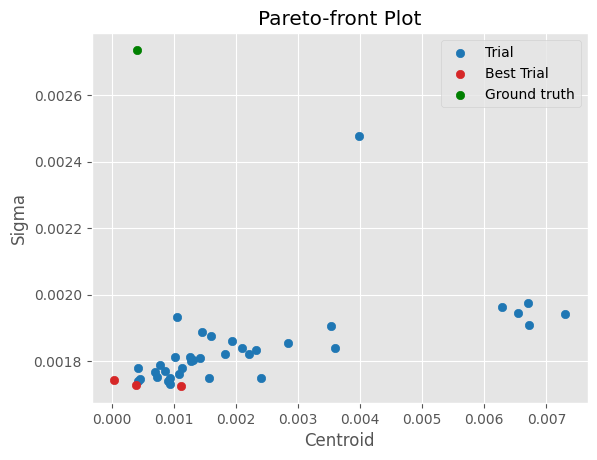

In [163]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Sigma')
plt.xlabel('Centroid')
plt.scatter(centroid_ground, sigma_ground, color='green', label='Ground truth')
plt.legend(loc='best')

In [164]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum())

-13.151979122265928
-16.4244690011505
-14.214184224589943


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

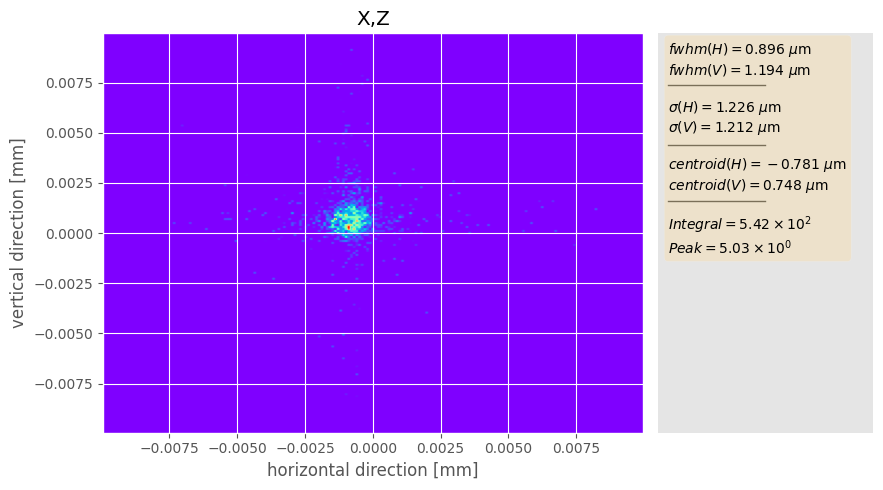

[4.222216804811069e-05, 0.0017434247806688843] 0.5390793114962008
BeamParameterOutput(parameter_value=9.816945689093482e-05, photon_beam=<orangecontrib.shadow.util.shadow_objects.ShadowBeam object at 0x7fe8ebefc790>, hist=<aps_ai.common.util.common.Histogram object at 0x7fe8789d99d0>, dw=<orangecontrib.ml.util.data_structures.DictionaryWrapper object at 0x7fe8882569a0>)


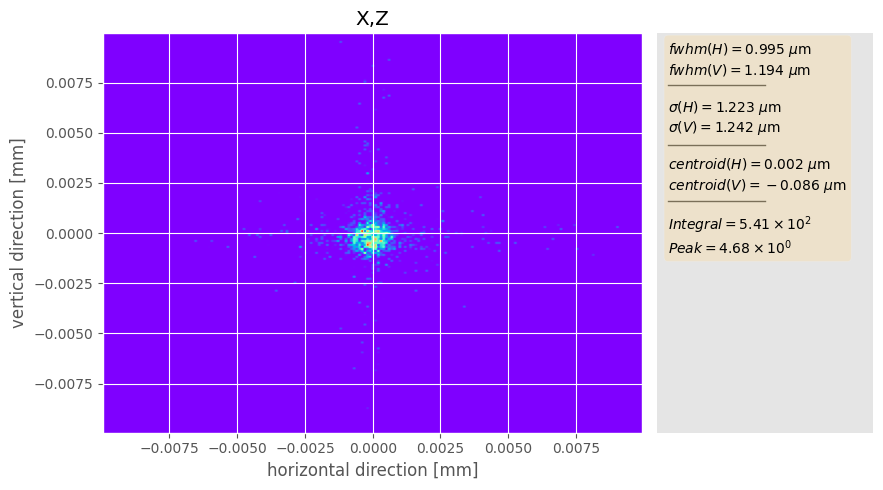

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Raytracing_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879/Downstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/tmp_work_dir_34-ID-66879

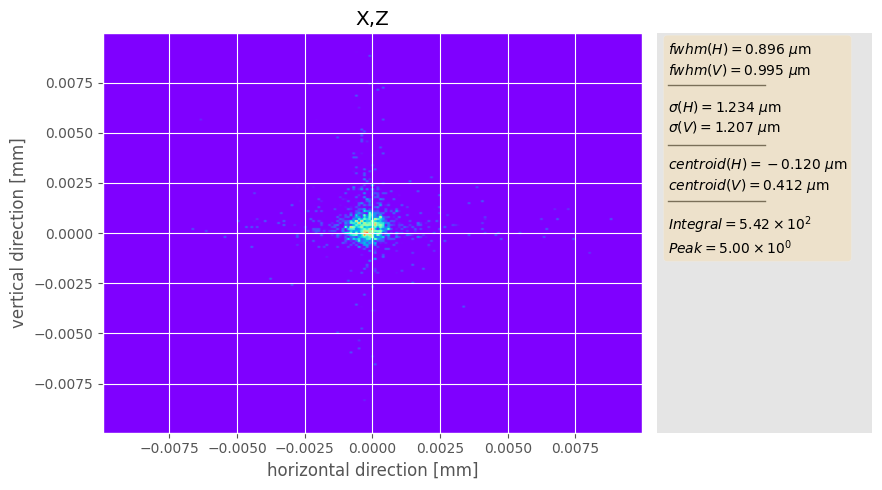

In [165]:
best_absolute_positions = []
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    pos_this = movers.get_absolute_positions(focusing_system, opt_trial.motor_types)
    best_absolute_positions.append(pos_this)
    print(t.values, t.user_attrs['wsum'])
    print(opt_common.get_centroid_distance(photon_beam=opt_trial.beam_state.photon_beam))
    plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)

In [166]:
tnums = []
centroids = []
sigmas = []
wsums = []
for t in opt_trial.study.trials:
    if t.state in [optuna.trial.TrialState.PRUNED, optuna.trial.TrialState.FAIL]:
        continue
    tnums.append(t.number)
    centroids.append(t.values[0])
    sigmas.append(t.values[1])
    wsums.append(t.user_attrs['wsum'])
    
tnums = np.array(tnums)
centroids = np.array(centroids)
sigmas = np.array(sigmas)
wsums = np.array(wsums)

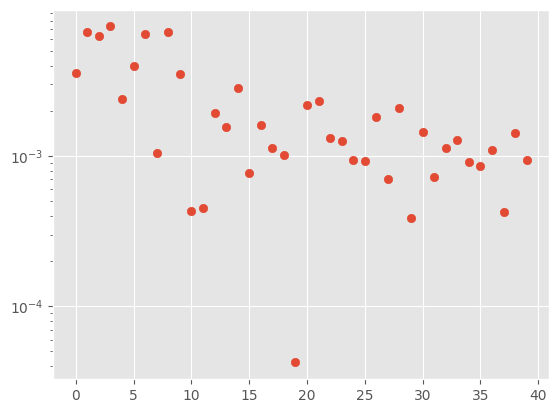

In [167]:
plt.scatter(tnums, centroids)
plt.yscale('log')

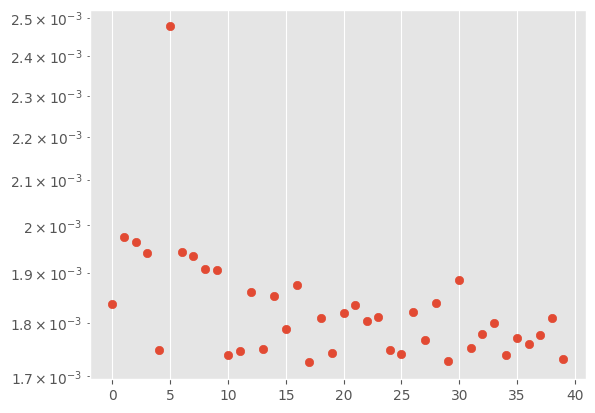

In [168]:
plt.scatter(tnums, sigmas)
plt.yscale('log')

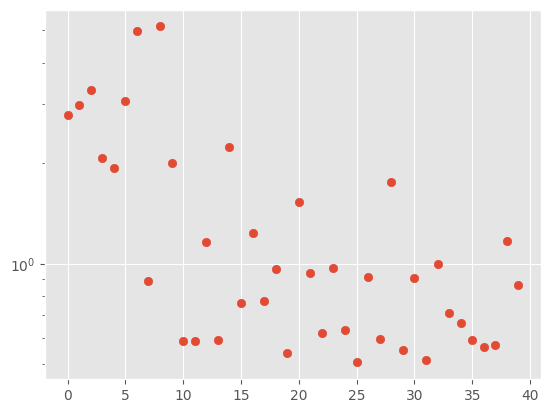

In [169]:
plt.scatter(tnums, wsums)
plt.yscale('log')

In [170]:
np.round(best_absolute_positions, 2)

array([[216.64, 143.  , 115.19, 227.16,   3.  ,   2.99,   0.81,   2.6 ],
       [216.64, 143.  , 115.19, 227.16,   3.  ,   2.99,  -0.39,   3.5 ],
       [217.32, 143.14, 114.39, 229.45,   3.  ,   2.99,  -0.29,   3.1 ]])

In [171]:
initial_absolute_positions

array([215.5, 144. , 112.5, 231.5,   3. ,   3. ,   0. ,   0. ])